## Table Of Content:
* [Introduction](#Yelp-Sentiment-Analysis)
* [Data](#Loading-Datasets)
* [EDA](#EDA)
* [Recommendation Systems)](#Recommendation-Systems)
* [Data Cleaning](#Data-Cleaning)
* [Topic Modeling](#Topic-Modeling)
    * [LSA](#LSA)
    * [NMF](#NMF)
    * [Corex](#Corex)
    * [Naming Topics](#Naming-Topics)

* [K-Means Clustering ](#K-Means-Clustering )
* [spaCy graph](#spaCy-graph)
* [Classification models](#Classification-models)
    * [Logistic Regression](#Logistic-Regression)
    * [MultinomialNB](#MultinomialNB)
    * [BernoulliNB ](#BernoulliNB )
    * [Weighted Logistic Regression](#Weighted-Logistic-Regression)
    * [Ada Boost](#Ada-Boost)
    * [Final Result (Logistic Regression)](#Final-Result-(Logistic-Regression))
* [Conclusion](#Conclusion)

    

    



# Yelp Sentiment Analysis

**Our goal is to build unsupervised Natural Language Processing (NLP) machine learning models to predict whether a business review text is positive or negative. Also, assigns topics(clustering) based on the raw text data to find out the business domains and implementing a recommendation system**




In [202]:
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.decomposition import TruncatedSVD ,NMF
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import scattertext as st
from gensim import corpora, models, similarities, matutils
from collections import defaultdict
import csv

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,VotingClassifier, RandomForestRegressor , ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import DBSCAN, SpectralClustering, MeanShift , KMeans
from sklearn.preprocessing import StandardScaler
import scipy.sparse as ss
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
from collections import Counter
from spacy.symbols import amod
from pprint import pprint
import pandas as pd
import pickle
from nltk.tokenize import TreebankWordTokenizer
import json
from autocorrect import Speller
spell = Speller(lang='en')
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords 
from sklearn.preprocessing import scale
from sklearn.utils import shuffle
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Loading Datasets

**the datasets from [Yelp](https://www.yelp.com/dataset) in json format**

In [ ]:

data_file = open("yelp_academic_dataset_review.json")
data = []
for line in data_file:
    data.append(json.loads(line))
reviews_df = pd.DataFrame(data)
data_file.close()

In [ ]:
data_file = open("yelp_academic_dataset_business.json")
data = []
for line in data_file:
    data.append(json.loads(line))
business_df = pd.DataFrame(data)
data_file.close()

In [ ]:
reviews_df.head()

In [ ]:
business_df.head()

dropping unwanted columns

In [ ]:
business_df_droped=business_df.drop(['address','postal_code','latitude','longitude','stars','is_open','hours','attributes'], axis=1)

In [ ]:
#merging the two datasets
dfall = pd.merge(reviews_df, business_df_droped)


In [ ]:
#data we will use
data= dfall.iloc[ : 500000]

### save the data using pickle 

In [ ]:
data.to_pickle("./data.pkl")

In [203]:
with open('data.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [204]:
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
1,hpcZLEzqD4_gPi6eSVi_Bg,Y-j2svl0M_5-jF1ehYuNPQ,buF9druCkbuXLX526sGELQ,2.0,1,1,1,I was really disappointed to say the least. I ...,2014-11-30 00:24:42,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
2,3FvY1Se8y2WXqTbaANOqMw,xUCX4GhBpeWxZB0l2lmt_w,buF9druCkbuXLX526sGELQ,5.0,3,0,0,This is as close to dining in Italy as you'll ...,2014-04-19 16:48:28,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
3,C1uQNP2ehBktS43ZRMEvkg,2M6KFsWIUXElqcQRz4A0Qg,buF9druCkbuXLX526sGELQ,5.0,1,2,0,Great food and service! Again. 4 out of the la...,2014-09-10 00:06:00,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."
4,Cja8_35_kQDnF9g4voikzw,t5SRIRU6INiAyVkiMJhRPA,buF9druCkbuXLX526sGELQ,1.0,0,0,0,We ordered the roasted chicken and homemade pa...,2014-08-24 23:53:23,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar..."


# EDA

for first graph its shows Top 10 cities by businesses

In [4]:
city_business_counts = data[['city', 'business_id']].groupby(['city'])\
['business_id'].agg('count').sort_values(ascending=False)

Text(0.5, 1.0, 'Top 10 cities by businesses listed')

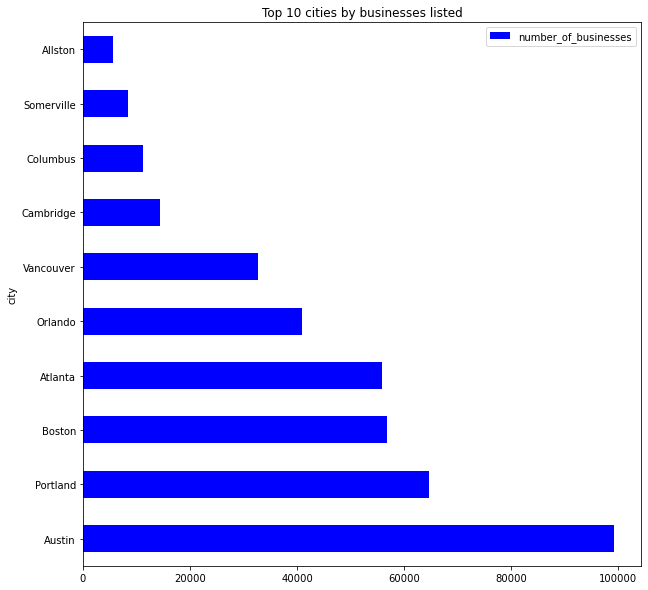

In [5]:
city_business_counts = pd.DataFrame(data=city_business_counts)
city_business_counts.rename(columns={'business_id' : 'number_of_businesses'}, inplace=True)

city_business_counts[0:10].sort_values(ascending=False, by="number_of_businesses")\
.plot(kind='barh', stacked=False, figsize=[10,10], colormap='winter')
plt.title('Top 10 cities by businesses listed')

In [6]:
city_business_reviews = data[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Austin,96323621,3.988438
Portland,38629427,3.939249
Boston,34642923,3.637171
Atlanta,28992633,3.746887
Orlando,20178312,3.701865
Vancouver,15010855,3.788858
Cambridge,5114172,3.677379
Columbus,4823692,3.855056
Winter Park,3375967,3.942227


Text(0.5, 1.0, 'Top 10 cities by reviews')

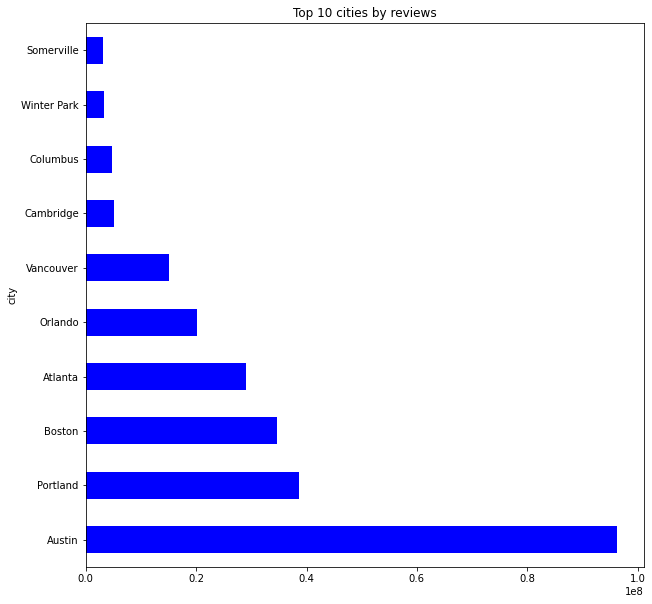

In [7]:
city_business_reviews['review_count'][0:10].plot(kind='barh', stacked=False, figsize=[10,10], \
                                                 colormap='winter')
plt.title('Top 10 cities by reviews')

for the above graph it shows which city has thhe most reviews

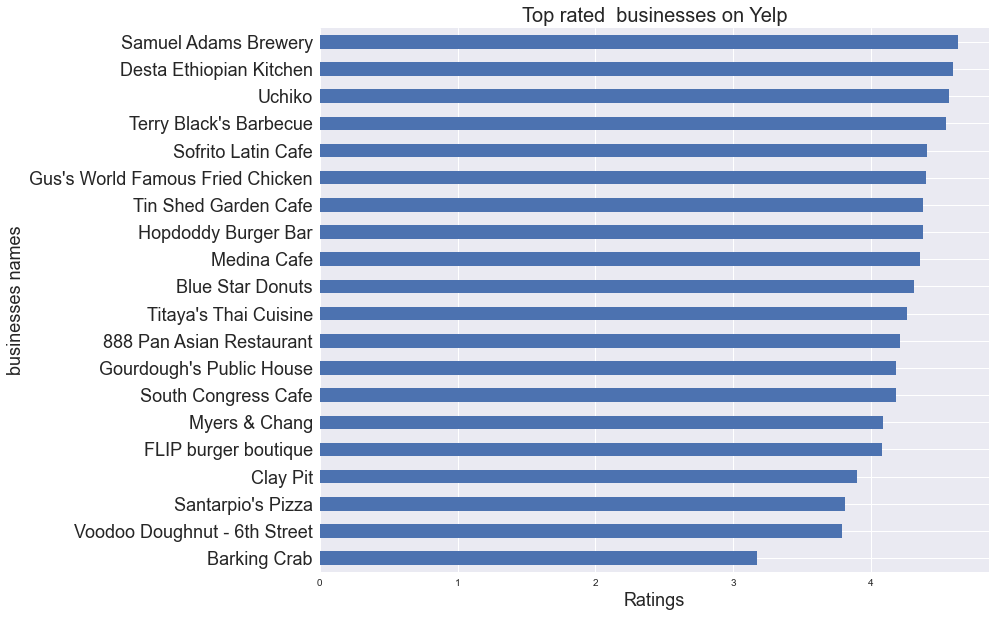

In [190]:
inefficient if we take all of the business name

top_businesses = data.name.value_counts().index[:20].tolist()

df_review_top = data.loc[data['name'].isin(top_businesses)]

df_review_top.groupby(data.name)['stars'].mean().sort_values(ascending=True).plot(kind='barh',figsize=(12, 10))

plt.yticks(fontsize=18)

plt.title('Top rated  businesses on Yelp',fontsize=20)

plt.ylabel('businesses names', fontsize=18)

plt.xlabel('Ratings', fontsize=18)

plt.show()

this graph shows top 20 businesses by rating

# Recommendation Systems

### Negative Recommendation system

for Negative Recommendation system we used simple metric and it gave us the similarities between negative rating 

In [205]:
neg_data_rec = data.copy()

In [206]:
# make ratings only positive or negative
neg_data_rec = neg_data_rec[neg_data_rec.stars!=3]

neg_data_rec['Sentiment'] = np.where(neg_data_rec['stars'] >= 4, 'positive', 'negative')
neg_data_rec

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories,Sentiment
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
1,hpcZLEzqD4_gPi6eSVi_Bg,Y-j2svl0M_5-jF1ehYuNPQ,buF9druCkbuXLX526sGELQ,2.0,1,1,1,I was really disappointed to say the least. I ...,2014-11-30 00:24:42,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
2,3FvY1Se8y2WXqTbaANOqMw,xUCX4GhBpeWxZB0l2lmt_w,buF9druCkbuXLX526sGELQ,5.0,3,0,0,This is as close to dining in Italy as you'll ...,2014-04-19 16:48:28,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
3,C1uQNP2ehBktS43ZRMEvkg,2M6KFsWIUXElqcQRz4A0Qg,buF9druCkbuXLX526sGELQ,5.0,1,2,0,Great food and service! Again. 4 out of the la...,2014-09-10 00:06:00,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
4,Cja8_35_kQDnF9g4voikzw,t5SRIRU6INiAyVkiMJhRPA,buF9druCkbuXLX526sGELQ,1.0,0,0,0,We ordered the roasted chicken and homemade pa...,2014-08-24 23:53:23,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,DkRfTZCResP1k_5edsvEXg,Tby7AZ4GDCzLSt0hMvp1jA,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,"I enjoyed my t-bone. It was cooked properly, t...",2014-11-26 15:58:38,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",positive
499996,_XruzQOrmGbDzni2lIviNg,3rLPO2RfKNjEHP5OjjT2wQ,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,Best steakhouse. It was hands down the best ri...,2014-11-26 03:57:07,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",positive
499997,xQEjjdTX17dw_KKtdf_gFA,I85HG2hja3RjZYJCEAS70A,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,"Eeshh, maybe we came on a bad night. I've neve...",2015-04-27 16:02:44,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative
499998,lzziw-nAVEzM1Xg-oHi-vg,938Xvklo_S3W7bZT0f1ivw,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,Not worth your money. First - The hostess on ...,2014-05-07 14:50:11,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative


In [207]:
#we want only negative ratings
neg_data_rec.Sentiment=np.where(~neg_data_rec.Sentiment.isin(['negative']), np.nan,neg_data_rec.Sentiment)


In [208]:
neg_data_rec

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories,Sentiment
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",NaN
1,hpcZLEzqD4_gPi6eSVi_Bg,Y-j2svl0M_5-jF1ehYuNPQ,buF9druCkbuXLX526sGELQ,2.0,1,1,1,I was really disappointed to say the least. I ...,2014-11-30 00:24:42,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
2,3FvY1Se8y2WXqTbaANOqMw,xUCX4GhBpeWxZB0l2lmt_w,buF9druCkbuXLX526sGELQ,5.0,3,0,0,This is as close to dining in Italy as you'll ...,2014-04-19 16:48:28,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",NaN
3,C1uQNP2ehBktS43ZRMEvkg,2M6KFsWIUXElqcQRz4A0Qg,buF9druCkbuXLX526sGELQ,5.0,1,2,0,Great food and service! Again. 4 out of the la...,2014-09-10 00:06:00,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",NaN
4,Cja8_35_kQDnF9g4voikzw,t5SRIRU6INiAyVkiMJhRPA,buF9druCkbuXLX526sGELQ,1.0,0,0,0,We ordered the roasted chicken and homemade pa...,2014-08-24 23:53:23,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,DkRfTZCResP1k_5edsvEXg,Tby7AZ4GDCzLSt0hMvp1jA,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,"I enjoyed my t-bone. It was cooked properly, t...",2014-11-26 15:58:38,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",NaN
499996,_XruzQOrmGbDzni2lIviNg,3rLPO2RfKNjEHP5OjjT2wQ,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,Best steakhouse. It was hands down the best ri...,2014-11-26 03:57:07,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",NaN
499997,xQEjjdTX17dw_KKtdf_gFA,I85HG2hja3RjZYJCEAS70A,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,"Eeshh, maybe we came on a bad night. I've neve...",2015-04-27 16:02:44,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative
499998,lzziw-nAVEzM1Xg-oHi-vg,938Xvklo_S3W7bZT0f1ivw,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,Not worth your money. First - The hostess on ...,2014-05-07 14:50:11,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative


In [209]:
neg_data_rec.dropna(inplace = True)

In [210]:
# drop unwanted colummns
neg_data_rec = neg_data_rec.drop(['useful','useful','review_id','funny','cool','text','date','city','state','review_count','categories','business_id','stars','Sentiment'],axis = 1)



In [211]:
neg_data_rec.head()

,user_id,name
1,Y-j2svl0M_5-jF1ehYuNPQ,Prides Osteria
4,t5SRIRU6INiAyVkiMJhRPA,Prides Osteria
6,1kM4jg4O-tFrmuBBnb8wdA,Prides Osteria
14,7NuAk35FPwEZ1HwVIV5vsw,Prides Osteria
16,u1Y6J-Ef4Skn8sJ1TpAoaw,Prides Osteria


In [212]:
neg_data_rec = neg_data_rec.drop_duplicates()

In [213]:
# save the data to csv file
    
neg_data_rec = pd.DataFrame(neg_data_rec)
neg_data_rec.to_csv(r'neg_data_rec.csv', index=False)

In [214]:
user_resturant_map = defaultdict(list)
resturant_user_map = defaultdict(list)

In [215]:
with open('neg_data_rec.csv', 'r') as csvfile:
    w = csv.reader(csvfile, delimiter=',')
    for row in w:
        user_resturant_map[row[0]].append((row[1]))
        resturant_user_map[row[1]].append((row[0]))

In [216]:
#show users that rate this restaurant
resturant_user_map['Prides Osteria']

['Y-j2svl0M_5-jF1ehYuNPQ',
 't5SRIRU6INiAyVkiMJhRPA',
 '1kM4jg4O-tFrmuBBnb8wdA',
 '7NuAk35FPwEZ1HwVIV5vsw',
 'u1Y6J-Ef4Skn8sJ1TpAoaw',
 'Pf4znQEWoL7DY1mntu2VeQ',
 '8DtqS0yhbIKrJJNDyKo2Ig',
 'ljvgd9ksG-q3ZY9loBwS6w',
 'g35OBHqo6AnJNMHSfp6IQw',
 'kAaoaiYkwzddLvOm4FVj1g',
 'Oc56GrSA7DhuU95WIqiG4g',
 'DIB4IaGdro00-pZI1Hz84w',
 '8iuZoPo2CCOfkdpzPqlbJA',
 'wvnwou32Tww-xf27yvFn2Q',
 'Wm5UpzeAJez0tE64OL3ELA',
 'sMRucNvjaoSrvo6Jo5yjhA',
 '3xDZ4iEwtiDISGtzV7uCEg',
 'cp_mCXj5NIVyQCr50qDKVw',
 'gN-xMARRCy4Q5cRwa0EkKg',
 'ei8D4-v1d_hecHHwNOzcFw',
 '1wWR8xICF5Gl7FW3ysmYew',
 'csAuIokHiykFWN-d8IBeeg',
 'Z13KzZdBxt4hBLIQkoah4w',
 'k3FF12JF7_453Tjp3crNxg']

In [332]:
# show what this user rated in business
user_resturant_map['t5SRIRU6INiAyVkiMJhRPA']

['Prides Osteria']

In [218]:
def get_similar_resturant(user_resturant_map,resturant_user_map,m):
    biglist = []
    for u in resturant_user_map[m]: # get all users that liked this business
        biglist.extend(user_resturant_map[u]) # find all other business those users liked and add to biglist
    return Counter(biglist).most_common(4)[1:] # use counter to 'count' the other business that show up most common

In [219]:
def get_resturant_recommendation(user_resturant_map,resturant_user_map,u1):
    biglist = []
    for m in user_resturant_map[u1]: # for the business a specific user likes
        for u in resturant_user_map[m]: # get other users who liked those businesses
            biglist.extend(user_resturant_map[u]) # find the other businesses those "similar folks" most liked
    return Counter(biglist).most_common(3) # return tuples of (most common business, count)

In [220]:
get_similar_resturant(user_resturant_map,resturant_user_map,'Finz Seafood & Grill')

[('Scratch Kitchen', 2),
 ('Howling Wolf Taqueria', 2),
 ('Engine House Pizza', 2)]

In [221]:
get_resturant_recommendation(user_resturant_map,resturant_user_map,'t5SRIRU6INiAyVkiMJhRPA')

[('Prides Osteria', 24), ('Bonchon Salem', 1), ("Santarpio's Pizza", 1)]

### Positive Recommendation system


In [222]:
pos_data_rec = data.copy()

In [223]:
pos_data_rec = pos_data_rec[pos_data_rec.stars!=3]

pos_data_rec['Sentiment'] = np.where(pos_data_rec['stars'] >= 4, 'positive', 'negative')

pos_data_rec.Sentiment=np.where(~pos_data_rec.Sentiment.isin(['positive']), np.nan,pos_data_rec.Sentiment)

pos_data_rec.dropna(inplace = True)

pos_data_rec = pos_data_rec.drop(['useful','useful','review_id','funny','cool','text','date','city','state','review_count','categories','business_id','stars','Sentiment'],axis = 1)


In [224]:
pos_data_rec

,user_id,name
0,ak0TdVmGKo4pwqdJSTLwWw,Prides Osteria
2,xUCX4GhBpeWxZB0l2lmt_w,Prides Osteria
3,2M6KFsWIUXElqcQRz4A0Qg,Prides Osteria
5,Kgz8xohZN1r2e-qN5GQ2pQ,Prides Osteria
8,l0gxisitVlPxXVQiIaEj7A,Prides Osteria
...,...,...
499990,_rOjeWpmV37qp9GT2qms7A,LongHorn Steakhouse
499991,5-NShszZeXZAXnxPMv3xcQ,LongHorn Steakhouse
499994,oh9371aJ34cA3M9hPUeClQ,LongHorn Steakhouse
499995,Tby7AZ4GDCzLSt0hMvp1jA,LongHorn Steakhouse


In [225]:
pos_data_rec_dum=pd.get_dummies(pos_data_rec['name'])

In [226]:
pos_data_rec = pd.concat([pos_data_rec,pos_data_rec_dum],axis=1)


In [227]:
pos_data_rec

,user_id,name,Gruby's New York Deli,1/2 Price Boxes,10 Nails,101 Bakery,126 Chinese Restaurant,163 Vietnamese Sandwiches & Bubble Tea,2 Polished Beauty,2 Rivers Contracting & Services,...,Zoe's Chinese Restaurant,Zoes Kitchen,Zona Salons,Zudaka Healthy Latin Food,Zunzi's,bartaco,ebike of COLORADO,iFLY Indoor Skydiving - Orlando,iGrille,iTech Electronics
0,ak0TdVmGKo4pwqdJSTLwWw,Prides Osteria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,xUCX4GhBpeWxZB0l2lmt_w,Prides Osteria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2M6KFsWIUXElqcQRz4A0Qg,Prides Osteria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Kgz8xohZN1r2e-qN5GQ2pQ,Prides Osteria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,l0gxisitVlPxXVQiIaEj7A,Prides Osteria,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499990,_rOjeWpmV37qp9GT2qms7A,LongHorn Steakhouse,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499991,5-NShszZeXZAXnxPMv3xcQ,LongHorn Steakhouse,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499994,oh9371aJ34cA3M9hPUeClQ,LongHorn Steakhouse,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
499995,Tby7AZ4GDCzLSt0hMvp1jA,LongHorn Steakhouse,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [228]:
pos_data_rec = pos_data_rec.drop(["name"], axis=1, errors="ignore")
pos_data_rec.head()

,user_id,Gruby's New York Deli,1/2 Price Boxes,10 Nails,101 Bakery,126 Chinese Restaurant,163 Vietnamese Sandwiches & Bubble Tea,2 Polished Beauty,2 Rivers Contracting & Services,204 Washington,...,Zoe's Chinese Restaurant,Zoes Kitchen,Zona Salons,Zudaka Healthy Latin Food,Zunzi's,bartaco,ebike of COLORADO,iFLY Indoor Skydiving - Orlando,iGrille,iTech Electronics
0,ak0TdVmGKo4pwqdJSTLwWw,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,xUCX4GhBpeWxZB0l2lmt_w,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2M6KFsWIUXElqcQRz4A0Qg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Kgz8xohZN1r2e-qN5GQ2pQ,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,l0gxisitVlPxXVQiIaEj7A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
pos_data_rec=pos_data_rec.drop_duplicates()

In [230]:
pos_data_rec.user_id.value_counts()

RtGqdDBvvBCjcu5dUqwfzA    80
j14WgRoU_-2ZE1aw1dXrJg    60
PI51J_fKhEfZKhi-MjWBpg    52
s8nkbQAlrVPfg1u4anGKtw    52
rcU7ysY41qGppbw4pQgjqg    50
                          ..
M-6Hu5nxHvXpQKZcMdSnPg     1
SORmXWGbqw7NckE5X7YxPQ     1
DeJW7JHdNipn7B5Gr5FWJQ     1
MZdxigKYlasxURDoIUQAww     1
HAPoRDzkKK5jvRAdIci-Qw     1
Name: user_id, Length: 231698, dtype: int64

In [231]:
pos_data_rec=pos_data_rec.groupby('user_id').sum()


In [232]:
pos_data_rec=pos_data_rec.reset_index()

pos_data_rec = pos_data_rec.drop(["user_id"], axis=1, errors="ignore")




In [233]:
pos_data_rec = pos_data_rec.rename(columns={"index": "user_id"})

In [244]:
pos_data_rec = pos_data_rec.reset_index()

In [245]:
pos_data_rec = pos_data_rec.rename(columns={"index": "user_id"})

In [248]:
pos_data_rec = pos_data_rec.set_index('user_id')

In [249]:
pos_data_rec

,Gruby's New York Deli,1/2 Price Boxes,10 Nails,101 Bakery,126 Chinese Restaurant,163 Vietnamese Sandwiches & Bubble Tea,2 Polished Beauty,2 Rivers Contracting & Services,204 Washington,22 Changes Salon & Spa,...,Zoe's Chinese Restaurant,Zoes Kitchen,Zona Salons,Zudaka Healthy Latin Food,Zunzi's,bartaco,ebike of COLORADO,iFLY Indoor Skydiving - Orlando,iGrille,iTech Electronics
user_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [250]:
#taking sample for SVD
sample = pos_data_rec.iloc[ : 5000]

In [251]:
from scipy.linalg import svd

U, Sigma, VT = svd(sample)

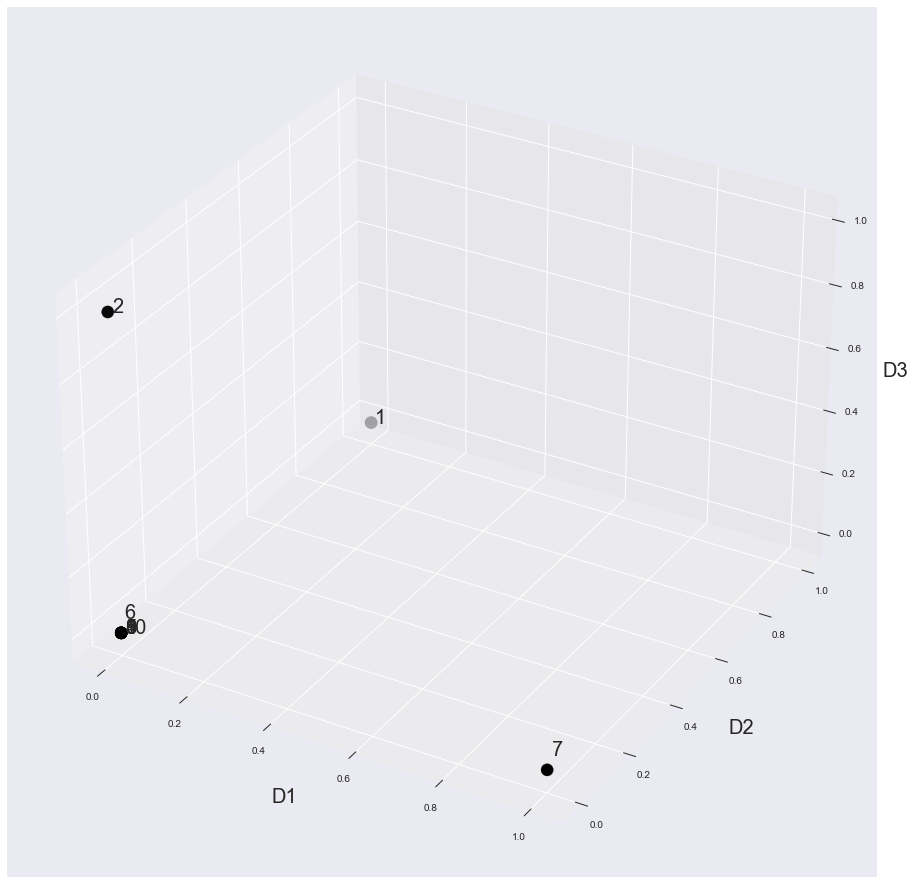

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('seaborn')

fig = plt.figure(figsize=(20,16))
ax = fig.gca(projection='3d')
ax.scatter(U[:,0],U[:,1],U[:,2],c='k',s=150);
ax.set_xlabel("D1", fontsize=20, labelpad=20)
ax.set_ylabel("D2", fontsize=20, labelpad=20)
ax.set_zlabel("D3", fontsize=20, labelpad=20);

lbls = sample.index
offset = 0.01
for i, txt in enumerate(lbls):
    if i not in [6,7]:
        ax.text(U[i,0]+offset,U[i,1],U[i,2],txt, fontsize=20)
    else:
        ax.text(U[i,0]+offset,U[i,1],U[i,2]+5*offset,txt, fontsize=20)



**this graph show the similarities between users where if the users are close to each other that mean they are more similar** 

In [261]:
User_list = sample.index
Businesses_names_list = sample.columns.str.replace("Business_Name_", "")
def get_recommends_user(userID, U, sample ,User_list , Businesses):
    userrecs = []
    for user in range(U.shape[0]):
        if user!= userID:
            userrecs.append([user,np.dot(U[userID],U[user])])
    final_rec = [i[0] for i in sorted(userrecs,key=lambda x: x[1],reverse=True)]
    comp_user = final_rec[0]
    print("User ID# %s is most similar to User ID# #%s "% (User_list[userID], User_list[comp_user]))
    rec_likes = sample.iloc[comp_user]
    current = sample.iloc[userID]
    recs = []
    for i,item in enumerate(current):
        if item != rec_likes[i] and rec_likes[i]!=0:
            recs.append(i)
    return recs
user_ID = 2
recommended_Businesses = get_recommends_user(user_ID,U,sample,User_list,Businesses_names_list)
if len(recommended_Businesses) > 10:
    first_10_recommeded_businesses = recommended_Businesses[0:10]#
else:
    first_10_recommeded_businesses = recommended_Businesses
print("There are %s businesses that user ID# %s did not visit" % (len(recommended_Businesses) ,User_list[user_ID]))
print("\n%s businesses for User ID# %s to check out:\n "% (len(first_10_recommeded_businesses) , User_list[user_ID]), list(Businesses_names_list[first_10_recommeded_businesses]))




User ID# 2 is most similar to User ID# #1335 
There are 1 businesses that user ID# 2 did not visit

1 businesses for User ID# 2 to check out:
  ['Yamato Sushi Restaurant']


# Data Cleaning

In [113]:
# make Sentiment only negative and positive , 1,2 for negarive  , 4,5 for positive
data = data[data.stars!=3]

data['Sentiment'] = np.where(data['stars'] >= 4, 'positive', 'negative')
data

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,name,city,state,review_count,categories,Sentiment
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
1,hpcZLEzqD4_gPi6eSVi_Bg,Y-j2svl0M_5-jF1ehYuNPQ,buF9druCkbuXLX526sGELQ,2.0,1,1,1,I was really disappointed to say the least. I ...,2014-11-30 00:24:42,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
2,3FvY1Se8y2WXqTbaANOqMw,xUCX4GhBpeWxZB0l2lmt_w,buF9druCkbuXLX526sGELQ,5.0,3,0,0,This is as close to dining in Italy as you'll ...,2014-04-19 16:48:28,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
3,C1uQNP2ehBktS43ZRMEvkg,2M6KFsWIUXElqcQRz4A0Qg,buF9druCkbuXLX526sGELQ,5.0,1,2,0,Great food and service! Again. 4 out of the la...,2014-09-10 00:06:00,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",positive
4,Cja8_35_kQDnF9g4voikzw,t5SRIRU6INiAyVkiMJhRPA,buF9druCkbuXLX526sGELQ,1.0,0,0,0,We ordered the roasted chicken and homemade pa...,2014-08-24 23:53:23,Prides Osteria,Beverly,MA,83,"Restaurants, Wine Bars, Nightlife, Farmers Mar...",negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,DkRfTZCResP1k_5edsvEXg,Tby7AZ4GDCzLSt0hMvp1jA,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,"I enjoyed my t-bone. It was cooked properly, t...",2014-11-26 15:58:38,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",positive
499996,_XruzQOrmGbDzni2lIviNg,3rLPO2RfKNjEHP5OjjT2wQ,lCUDJs7wKtb7BltiLRphWQ,5.0,0,0,0,Best steakhouse. It was hands down the best ri...,2014-11-26 03:57:07,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",positive
499997,xQEjjdTX17dw_KKtdf_gFA,I85HG2hja3RjZYJCEAS70A,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,"Eeshh, maybe we came on a bad night. I've neve...",2015-04-27 16:02:44,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative
499998,lzziw-nAVEzM1Xg-oHi-vg,938Xvklo_S3W7bZT0f1ivw,lCUDJs7wKtb7BltiLRphWQ,2.0,0,0,0,Not worth your money. First - The hostess on ...,2014-05-07 14:50:11,LongHorn Steakhouse,Reading,MA,169,"Barbeque, American (Traditional), Restaurants,...",negative


In [114]:
# take only english words
data = data[data['text'].map(lambda x: x.isascii())]

In [ ]:
# spell checking
data['text'] = data['text'].map(lambda x: spell(x))


In [ ]:
# it takes long time so we save it in pickle
data.to_pickle("./data_after_spell.pkl")

In [262]:
with open('data_after_spell.pkl','rb') as read_file:
    data= pickle.load(read_file)

In [263]:
#check for alphanumeric , punctuation and repeated characteristics and remove thim
alphanumeric=lambda x: re.sub('\w*\d\w*','',x)
punc_lower=lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x.lower())

repeated_chars = lambda x: re.sub('(.)\1{2,}', '\1', x)


data['text']=data.text.map(alphanumeric).map(punc_lower).map(repeated_chars)

In [264]:
# cleaning function

ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):

    listofwords = sentence.strip().split()          # to remove any space from beginning and the end of text
    listof_words = []    
    for word in listofwords:
        if not word in ENGLISH_STOP_WORDS:
            lemm_word = WordNetLemmatizer().lemmatize(word)
            # remove the stop words
            for punctuation_mark in string.punctuation:
                word = word.replace(punctuation_mark, '')
            if len(word)>0:
                listof_words.append(word)
    return(listof_words)

In [265]:
cleaned_text = data.text


In [266]:
#adding costum stop words
stop_words = text.ENGLISH_STOP_WORDS.union(['didnt','havent', 'week', 'hi','wa','ha','day','today','really','also',
                                            'go', 'us', 'dont', 'got', 'im', 'ive','burger','food' ,'came', 'back',
                                           'get','try', 'would', 'time','good','great','service','large','order','les'
                                           ,'like','best','nice','love','pretty','extra', 'minutes','long','soft'
                                           ,'delicious', 'amazing','come','went','raven','definitely','friendly'
                                           ,'austin','boston','burgers','experience', 'people', 'better','make', 'favorite'
                                            , 'price','going','place','think','room','wait','way','know'
                                           ,'say','right','wanted','wasnt','took','told','left','asked','said'
                                           ,'small','little','want','youre','lot','big','quite','probably','maybe'
                                            ,'bit','novella','flip','tried','thierry','ordered','pho','sure'
                                           ,'help', 'awesome', 'excellent', 'perfect','recommend','risky','vancouver'
                                            ,'wonderful', 'use', 'used','willamette','bad','actually','things','isip'
                                            ,'spring', 'usually', 'new','fast','run','moving','getting', 'taking','hotel'
                                           ,'thats','thing','away','eat','looked','times','need','fact','thought'
                                            ,'look','doesnt','isnt','yes','walk','finally','let','waiting','walked','tell'
                                            ,'gave','check','later','feel','id','trying','oh','kind','looking','star','comes'
                                            ,'old','theres','different','home','ill','high','theyre','hard','mind',
                                            'mean','years', 'pay', 'money','called','pad','needed'
                                            ,'actresses','similar','relatively','pleasant','ow','opinion','impressed',
                                            'husbands','aside','wanting','unlike','treats','strange','st','sort','smooth'])





In [267]:
# define TF-IDF vectorizer
Tf_vectorizer = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words = stop_words).fit(cleaned_text)
text_tf = Tf_vectorizer.transform(cleaned_text)

In [268]:
# define Count vectorizer
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(cleaned_text)
text_cv = C_vectorizer.transform(cleaned_text)

# Topic Modeling

**For topic modeling we will use LSA , NMF , Corex with Count vectorizer or TF-IDF and compare them.**

# LSA

#### LSA Count Vectorizer

In [269]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(text_cv)
lsa.explained_variance_ratio_

array([0.0154473 , 0.00957354, 0.00750447, 0.00743894, 0.00588835,
       0.00575122])

In [270]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["1","2",'3','4','5','6'],
             columns = C_vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaaaa,aaron,ab,abandoned,abbr,ability,able,abrupt,...,yyyy,z,zen,zero,zip,zoes,zone,zones,zoo,zucchini
1,0.000,0.002,0.001,0.0,0.0,0.0,0.001,0.002,0.039,0.0,...,0.0,0.000,0.001,0.005,0.0,0.000,0.001,0.000,0.001,0.003
2,0.001,-0.001,0.000,0.0,0.0,0.0,0.000,0.002,0.042,0.0,...,0.0,0.001,-0.000,0.007,0.0,-0.001,0.001,0.001,0.001,-0.002
3,0.001,0.001,0.000,0.0,0.0,0.0,-0.000,0.000,0.019,0.0,...,0.0,0.001,0.000,0.004,0.0,0.000,0.001,0.000,0.000,-0.001
4,0.000,-0.001,-0.000,-0.0,0.0,-0.0,-0.000,-0.000,-0.000,0.0,...,-0.0,0.000,-0.001,0.001,0.0,-0.000,0.000,0.000,0.000,0.000
5,0.001,-0.001,-0.000,-0.0,-0.0,-0.0,0.000,-0.000,-0.009,0.0,...,-0.0,0.000,0.001,0.001,-0.0,0.000,-0.001,-0.001,-0.000,0.001
6,0.000,0.002,0.000,-0.0,-0.0,-0.0,0.001,0.000,0.001,-0.0,...,0.0,0.000,0.002,-0.002,0.0,0.000,0.000,-0.000,0.000,0.002


In [271]:
def display_topics(model , feature_names, no_top_words, topic_names = None):
    for ix , topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic: ", ix)
        else:
            print('\nTopic: "',topic_names[ix],'"')
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

display_topics(lsa, C_vectorizer.get_feature_names(), 20)


Topic:  0
restaurant, chicken, menu, table, sauce, bar, night, staff, cheese, meal, dinner, fresh, salad, fried, drinks, dish, pizza, server, area, lunch

Topic:  1
car, staff, bar, work, customer, manager, night, hour, table, drinks, coffee, hair, hours, location, phone, business, area, drink, line, free

Topic:  2
car, chicken, fried, work, rice, customer, rental, honda, phone, company, cars, spicy, days, dealership, sandwich, hair, vehicle, drive, hours, appointment

Topic:  3
pizza, car, cheese, crust, chicken, sauce, topping, slice, sausage, garlic, salad, pepperoni, pie, slices, delivery, fresh, work, customer, crisp, sandwich

Topic:  4
restaurant, car, dish, sushi, pizza, sauce, menu, meal, dishes, rice, soup, fish, dinner, pork, restaurants, shrimp, roll, thai, beef, noodles

Topic:  5
coffee, sauce, cream, fresh, sweet, chocolate, cheese, ice, flavor, menu, breakfast, pork, taste, beef, sushi, hot, meat, fish, tea, dish


topics here are not that clear

#### LSA TF-IDF

In [272]:
lsa = TruncatedSVD(6)
doc_topic = lsa.fit_transform(text_tf)
lsa.explained_variance_ratio_

array([0.00207849, 0.00419402, 0.00380936, 0.00298926, 0.00277127,
       0.00262663])

In [273]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["first","second",'third','fourth','5','6'],
             columns = Tf_vectorizer.get_feature_names())
topic_word

,aa,aaa,aaaaaa,aaron,ab,abandoned,abbr,ability,able,abrupt,...,yyyy,z,zen,zero,zip,zoes,zone,zones,zoo,zucchini
first,0.001,0.005,0.001,0.001,0.0,0.001,0.001,0.002,0.033,0.001,...,0.001,0.001,0.002,0.006,0.001,0.001,0.002,0.000,0.001,0.003
second,-0.000,-0.003,-0.000,-0.000,0.0,-0.000,-0.000,-0.000,-0.005,0.000,...,-0.000,-0.000,-0.001,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.001
third,-0.001,0.002,-0.000,-0.001,-0.0,-0.000,-0.000,-0.002,-0.026,-0.000,...,-0.000,-0.000,0.001,-0.006,-0.000,0.001,-0.001,-0.001,-0.001,0.003
fourth,0.000,0.002,0.000,-0.000,0.0,-0.000,-0.001,-0.001,-0.003,-0.000,...,0.000,-0.000,-0.002,-0.002,0.000,-0.000,0.000,0.000,0.000,-0.000
5,-0.000,0.002,-0.000,-0.000,-0.0,-0.000,0.001,-0.000,-0.019,-0.000,...,-0.000,-0.000,0.006,-0.007,-0.000,0.000,-0.001,-0.000,-0.000,-0.001
6,-0.001,0.004,-0.001,0.000,-0.0,-0.000,-0.001,-0.002,-0.031,-0.001,...,0.000,-0.001,-0.003,-0.013,-0.001,-0.001,-0.001,-0.001,-0.001,0.001


In [274]:
display_topics(lsa, Tf_vectorizer.get_feature_names(), 20)


Topic:  0
chicken, restaurant, staff, menu, pizza, bar, fresh, lunch, night, drinks, table, dinner, atmosphere, sauce, cheese, meal, salad, super, fried, area

Topic:  1
pizza, crust, cheese, slice, topping, pepperoni, delivery, slices, sauce, sausage, garlic, italian, pie, dough, pasta, oven, santarpios, ingredients, beer, wings

Topic:  2
chicken, fried, rice, sauce, spicy, salad, soup, thai, cheese, pork, beef, sandwich, lunch, meat, fresh, noodles, flavor, shrimp, crisp, dish

Topic:  3
coffee, breakfast, shop, sandwich, eggs, debuts, chicken, ticos, branch, cheese, bacon, cream, toast, chocolate, sweet, morning, spot, super, ice, french

Topic:  4
sushi, fresh, coffee, thai, roll, staff, rolls, breakfast, restaurant, lunch, fish, quality, soup, prices, ticos, pizza, menu, super, noodles, authentic

Topic:  5
beer, atmosphere, bar, drinks, menu, selection, ticos, wine, fun, spot, night, breakfast, dinner, music, bartender, branch, drink, beers, staff, loved


# NMF

#### NMF Count Vectrizor

In [277]:
nmf_model_cv = NMF(6)
nmf_doc_topic = nmf_model_cv.fit_transform(text_cv)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
            index = ["1","2",'3','4','5','6'],
             columns = C_vectorizer.get_feature_names())

display_topics(nmf_model_cv , C_vectorizer.get_feature_names(),20)


Topic:  0
sauce, menu, cheese, fresh, dish, sweet, pork, flavor, salad, meat, taste, beef, meal, rice, fish, spicy, lunch, soup, cream, hot

Topic:  1
bar, staff, night, drinks, table, drink, beer, area, coffee, hour, friends, happy, work, location, free, line, bartender, server, parking, friend

Topic:  2
car, customer, work, manager, rental, honda, phone, cars, company, dealership, hours, vehicle, business, days, drive, oil, sales, guy, change, appointment

Topic:  3
pizza, cheese, crust, sauce, topping, slice, sausage, salad, pepperoni, garlic, pie, slices, fresh, italian, delivery, bread, oven, half, dough, pasta

Topic:  4
restaurant, table, menu, meal, server, dinner, waitress, restaurants, waiter, seated, dining, dishes, wine, manager, tables, dish, reservation, dessert, party, family

Topic:  5
chicken, fried, rice, sandwich, salad, spicy, sauce, crisp, lunch, fries, hot, wings, sides, curry, thai, soup, juicy, beans, cheese, dry


here topics are the most clear for us

#### NMF TF-IDF

In [130]:
nmf_model_tf = NMF(6)
doc_topic = nmf_model.fit_transform(text_tf)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
            index = ["first","second",'3','4','5','6'],
             columns = Tf_vectorizer.get_feature_names())

display_topics(nmf_model , Tf_vectorizer.get_feature_names(),20)

/Users/abuda7m/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic:  0
restaurant, bar, drinks, menu, night, table, atmosphere, dinner, beer, server, wine, drink, happy, hour, friends, meal, fun, waitress, bartender, selection

Topic:  1
pizza, crust, cheese, slice, topping, sauce, pepperoni, delivery, slices, sausage, fresh, garlic, italian, pie, salad, pasta, dough, ingredients, oven, bread

Topic:  2
chicken, fried, sauce, rice, spicy, sandwich, cheese, salad, soup, pork, beef, lunch, fries, meat, thai, flavor, hot, fresh, sweet, noodles

Topic:  3
coffee, breakfast, shop, eggs, branch, debuts, cream, spot, chocolate, toast, ticos, late, ice, morning, bacon, cup, portland, pancake, sweet, cafe

Topic:  4
sushi, fresh, roll, rolls, fish, quality, tuna, sashimi, salmon, prices, lunch, restaurant, japanese, temporal, spicy, lobster, rice, places, happy, soup

Topic:  5
staff, car, customer, work, location, super, clean, hair, helpful, job, line, care, store, business, manager, highly, rude, hours, prices, guys


# Corex

#### Corex count vectorizer

In [131]:
vectorizer = CountVectorizer(max_features=2000,
                            stop_words=stop_words,tokenizer=my_tokenizer,
                            binary=True)
doc_word = vectorizer.fit_transform(cleaned_text)
words = list(np.asarray(vectorizer.get_feature_names()))

In [132]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=cleaned_text)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: manager,car,customer,phone,work,review,person,business,customers,paid
1: sauce,chicken,cheese,fried,rice,salad,pork,meat,spicy,beef
2: menu,dish,meal,dessert,cream,sweet,restaurant,taste,chocolate,dinner
3: table,night,seated,arrived,tables,server,sat,decided,drink,waitress
4: parking,street,free,places,location,park,line,located,makes,coffee
5: bar,beer,wine,seating,music,selection,beers,area,outside,patio


#### Corex TF-IDF

In [ ]:
TFVectorizer = TfidfVectorizer(max_features=2000,
                            stop_words=stop_words,tokenizer=my_tokenizer,
                            binary=True)
doc_word = TFVectorizer.fit_transform(cleaned_text)
words = list(np.asarray(TFVectorizer.get_feature_names()))

In [ ]:
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=cleaned_text)
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

**From above results we found Count vectorizer NMF with 6 Topics are the best**

# Naming Topics

In [329]:
topics_by_busniess = pd.DataFrame(nmf_doc_topic, columns = ['food_menu', 'bars','Automotive','Italian_food','restaurant','Asian_food'])
topics_by_busniess['main_topic'] = topics_by_busniess.idxmax(axis=1)
topics_by_busniess['text'] = data['text']

In [330]:
topics_by_busniess.dropna(inplace = True)
topics_by_busniess

,food_menu,bars,Automotive,Italian_food,restaurant,Asian_food,main_topic,text
1,0.005420,0.010871,0.000000,0.000738,0.009143,0.000000,bars,i was really disappointed to say the least i s...
2,0.000000,0.001401,0.001114,0.000061,0.000000,0.000072,bars,this is as close to dining in italy as youll f...
3,0.004036,0.000000,0.000000,0.005299,0.003928,0.098832,Asian_food,great food and service again out of the last ...
4,0.038530,0.035392,0.000000,0.000000,0.008337,0.000000,food_menu,we ordered the roasted chicken and homemade pa...
5,0.000000,0.029129,0.000000,0.000000,0.010479,0.000000,bars,a gem tucked away in beverly the atmosphere is...
...,...,...,...,...,...,...,...,...
429852,0.012072,0.009941,0.000000,0.001331,0.000000,0.001923,food_menu,if i could rate this place no stars i would i ...
429853,0.005507,0.004194,0.000000,0.000000,0.000866,0.000000,food_menu,its taken me since sunday to be able to calm d...
429854,0.017430,0.048520,0.000000,0.000950,0.010234,0.000599,bars,lisa made all my nail dreams come true i show ...
429855,0.009798,0.035689,0.000000,0.000000,0.083779,0.000000,restaurant,i waited for a short while and then had a pedi...


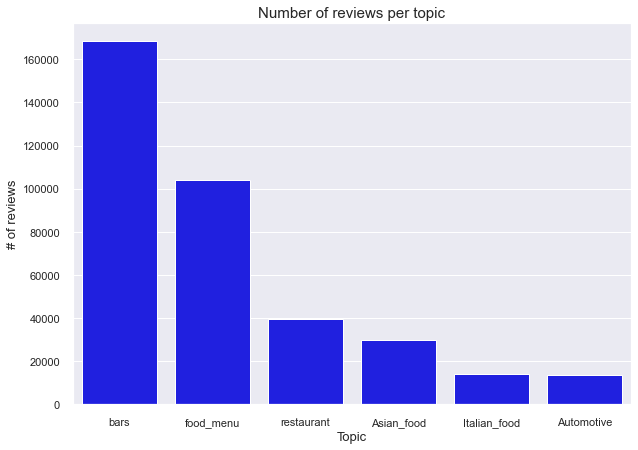

In [331]:
sns.set(rc={'figure.figsize':(10,7)})
ax = sns.countplot(x="main_topic",data=topics_by_busniess,color='blue', order = topics_by_busniess['main_topic'].value_counts().index );
ax.set_xlabel("Topic",fontsize=13);
ax.set_ylabel("# of reviews",fontsize=13);
ax.set_title('Number of reviews per topic',fontsize=15);


the above graph shows the most reviews per topic

#  K-Means Clustering 

In [192]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(text_cv)
    distortions.append(kmeanModel.inertia_)

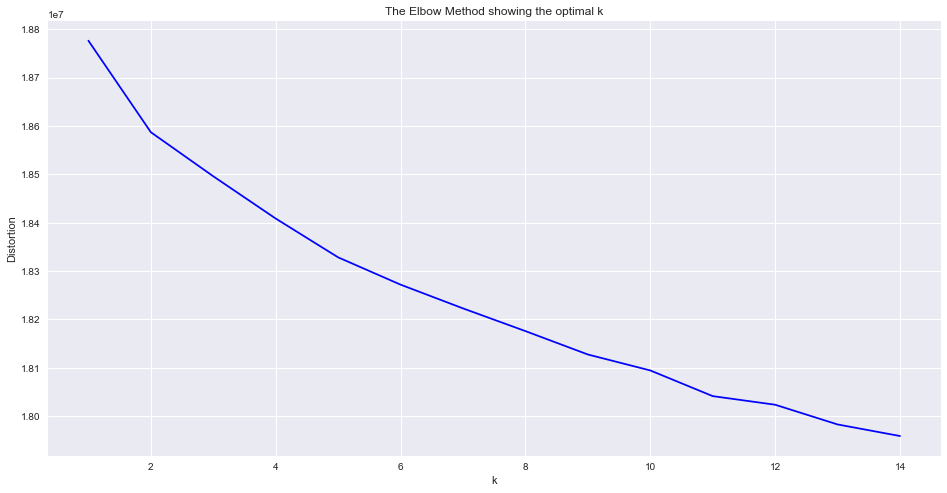

In [193]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [194]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(text_tf)
    distortions.append(kmeanModel.inertia_)

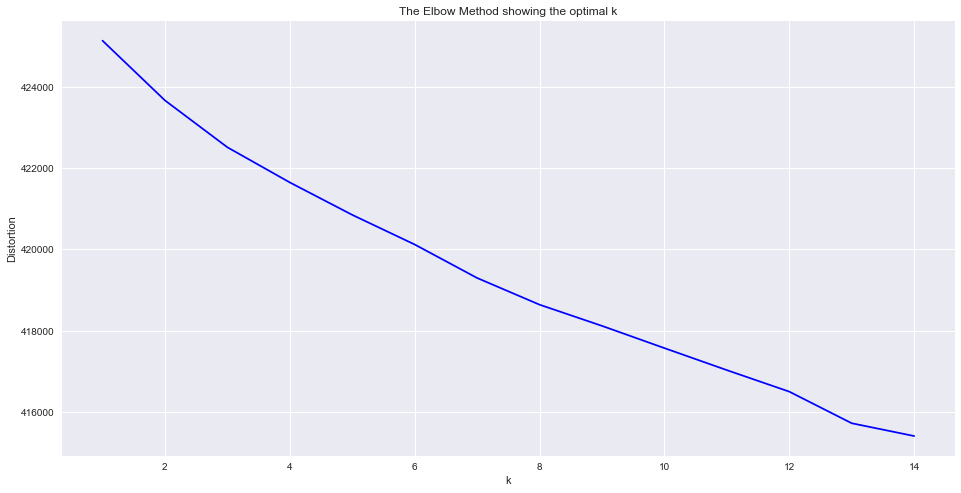

In [195]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

the elbow graphs tell us how many cluster we can use but here its note clear for us

# spaCy graph

In [183]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")
#stops = nlp.Defaults.stop_words |= {"my_new_stopword1","my_new_stopword2",}

#cleaning function
def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

data['Text_After_Clean'] = data['text'].apply(normalize, lowercase=True, remove_stopwords=True)

/Users/abuda7m/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
# Scattertext

corpus = st.CorpusFromPandas(data,
                             category_col='Sentiment',
                             text_col='Text_After_Clean',
                             nlp=st.whitespace_nlp_with_sentences
                            ).build()

html = st.produce_scattertext_explorer(
        corpus,
        category='positive',
        category_name='Positive',
        not_category_name='negative',
        minimum_term_frequency=10,
        pmi_threshold_coefficient=5,
        width_in_pixels=1000,
        metadata=data['name'],
        )

In [ ]:
open('demo3.html', 'wb').write(html.encode('utf-8'));

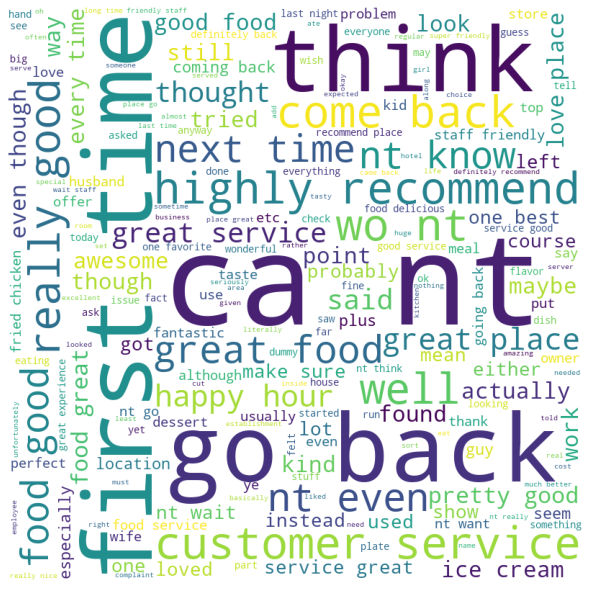

In [197]:
#word cloud
from wordcloud import WordCloud, STOPWORDS

  
comment_words = ''
stopwords = set(STOPWORDS)
 


for val in data.Text_After_Clean:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 


wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

here we have the most words that used in our data

# Classification models

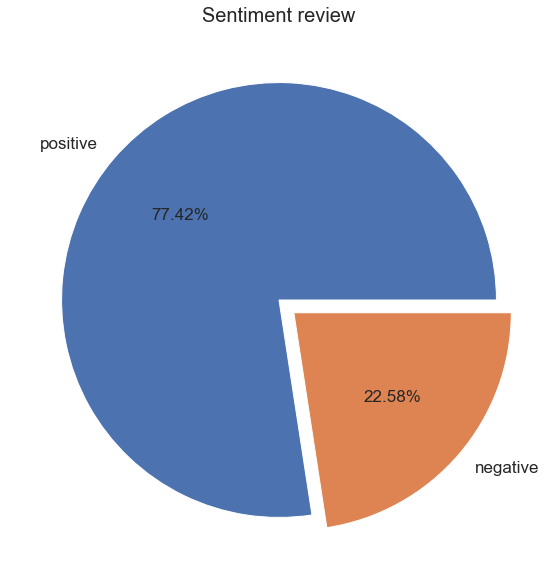

In [333]:
plt.figure(figsize=(10,10))
plt.pie(x=data['Sentiment'].value_counts(),labels=['positive','negative'],autopct='%.2f%%',textprops={'fontsize': 17},explode=[0,0.09],)
plt.title('Sentiment review',fontdict={'fontsize':20})
plt.show()

our target seems unbalanced so we will tri weighted Logistic Regression to see if its enhance accuracy and f1-score

assign our target and columns then splitting the data 

In [286]:
X = data.text
y = data.Sentiment

In [287]:
 data.Sentiment.unique()

array(['negative', 'positive'], dtype=object)

In [288]:
Xrem, X_train, yrem, y_train = train_test_split(X, y, test_size=0.9, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(Xrem, yrem, test_size=0.5, random_state=42)

define Count Vectorizer and TF-IDF

In [289]:
Tf_vectorizer = TfidfVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words = stop_words).fit(X_train)
X_train_tf = Tf_vectorizer.transform(X_train)
X_val1_tf = Tf_vectorizer.transform(X_val)
X_test_tf = Tf_vectorizer.transform(X_test)

In [290]:
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(X_train)
X_train_cv = C_vectorizer.transform(X_train)
X_val1_cv = C_vectorizer.transform(X_val)
X_test_cv = C_vectorizer.transform(X_test)

# Logistic Regression

In [291]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
lr = LogisticRegression()

In [292]:
lr.fit(X_train_cv, y_train)
print('The accuracy for training : ',lr.score(X_train_cv,y_train))
print('The accuracy for validation: ',lr.score(X_val1_cv,y_val))

The accuracy for training :  0.9441985979858971
The accuracy for validation:  0.9360227061232086


In [293]:
lr.fit(X_train_tf, y_train)
print('The accuracy for training : ',lr.score(X_train_tf,y_train))
print('The accuracy for validation: ',lr.score(X_val1_tf,y_val))

The accuracy for training :  0.9406470357120701
The accuracy for validation:  0.9371394007072399


In [163]:
# Create a function to calculate the error metrics, since we'll be doing this several times
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results

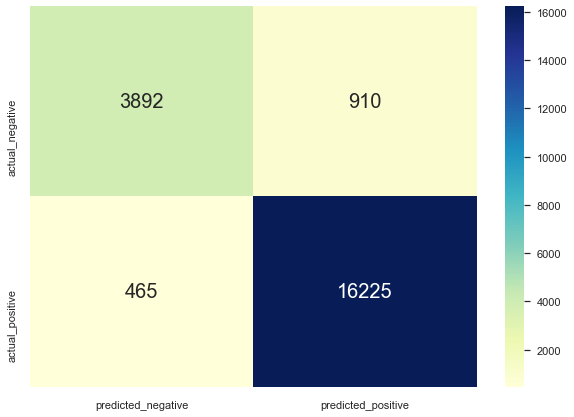

In [308]:
lr.fit(X_train_cv , y_train)
y_pred_cv1 = lr.predict(X_val1_cv)
cm1 = conf_matrix(y_val , y_pred_cv1)

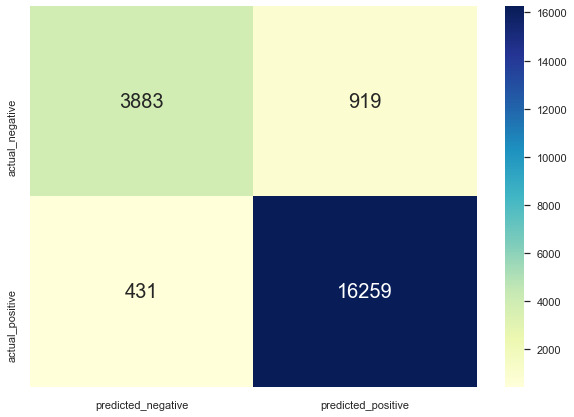

In [309]:
lr.fit(X_train_tf , y_train)
y_pred_tf1 = lr.predict(X_val1_tf)
cm2 = conf_matrix(y_val , y_pred_tf1)

# MultinomialNB

In [294]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train_cv, y_train)

print('The accuracy for training : ',mnb.score(X_train_cv,y_train))
print('The accuracy for validation: ',mnb.score(X_val1_cv,y_val))

The accuracy for training :  0.8918712132178085
The accuracy for validation:  0.8917736832309696


In [295]:

mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)

print('The accuracy for training : ',mnb.score(X_train_tf,y_train))
print('The accuracy for validation: ',mnb.score(X_val1_tf,y_val))

The accuracy for training :  0.898602121631961
The accuracy for validation:  0.8982877349711521


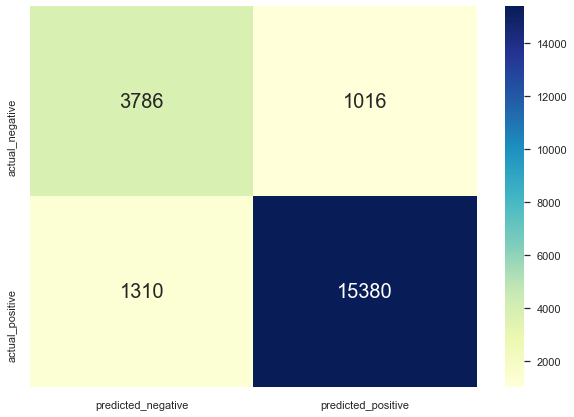

In [310]:
mnb.fit(X_train_cv , y_train)
y_pred_cv2 = mnb.predict(X_val1_cv)
cm3 = conf_matrix(y_val , y_pred_cv2)

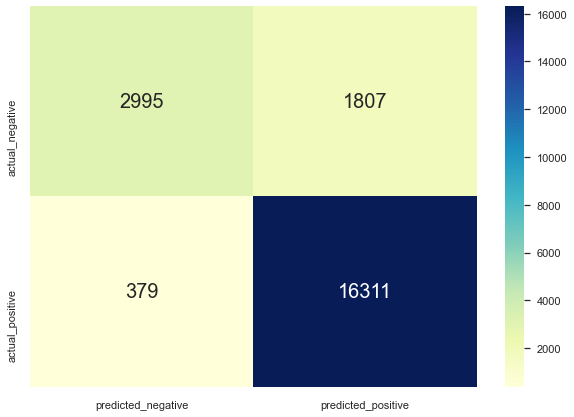

In [311]:
mnb.fit(X_train_tf , y_train)
y_pred_tf2 = mnb.predict(X_val1_tf)
cm4 = conf_matrix(y_val , y_pred_tf2)

# BernoulliNB 

In [296]:
# Fit the second Naive Bayes model
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_cv, y_train)

print('The accuracy for training : ',bnb.score(X_train_cv,y_train))
print('The accuracy for validation: ',bnb.score(X_val1_cv,y_val))

The accuracy for training :  0.8700164395458964
The accuracy for validation:  0.8718127675414108


In [177]:

bnb = BernoulliNB()
bnb.fit(X_train_tf, y_train)

print('The accuracy for training : ',bnb.score(X_train_tf,y_train))
print('The accuracy for validation: ',bnb.score(X_val1_tf,y_val))

The accuracy for training :  0.8700164395458964
The accuracy for validation:  0.8718127675414108


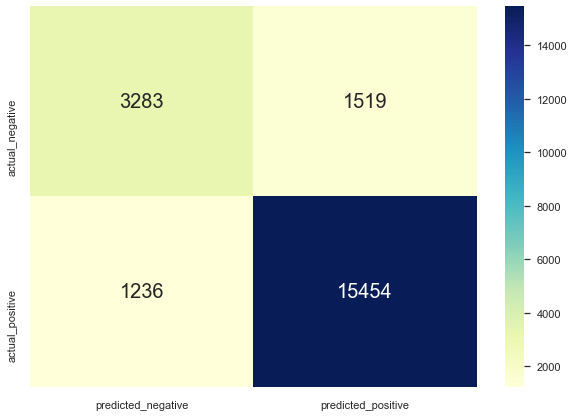

In [312]:
bnb.fit(X_train_cv , y_train)
y_pred_cv3 = bnb.predict(X_val1_cv)
cm5 = conf_matrix(y_val , y_pred_cv3)

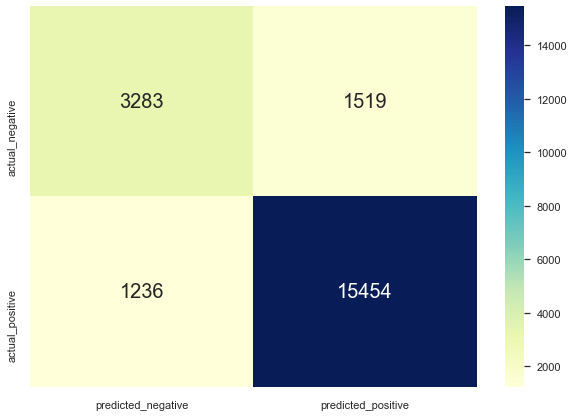

In [313]:
bnb.fit(X_train_tf , y_train)
y_pred_tf3 = bnb.predict(X_val1_tf)
cm6 = conf_matrix(y_val , y_pred_tf3)

# Weighted Logistic Regression

In [297]:
LR_CLF_2X = LogisticRegression(class_weight={"positive" : 1, "negative" : 3}, solver='liblinear')
LR_CLF_2X.fit(X_train_cv, y_train)
print('The accuracy for training : ',LR_CLF_2X.score(X_train_cv,y_train))
print('The accuracy for validation: ',LR_CLF_2X.score(X_val1_cv,y_val))

The accuracy for training :  0.9387782005417813
The accuracy for validation:  0.9275544388609716


In [301]:
LR_CLF_2X.fit(X_train_tf, y_train)
print('The accuracy for training : ',LR_CLF_2X.score(X_train_tf,y_train))
print('The accuracy for validation: ',LR_CLF_2X.score(X_val1_tf,y_val))

The accuracy for training :  0.9345339026861598
The accuracy for validation:  0.9271822073329611


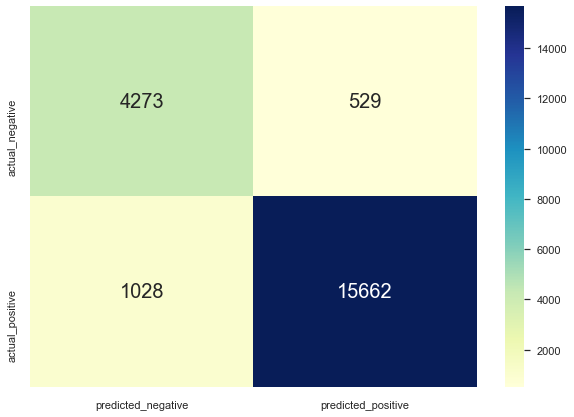

In [314]:
LR_CLF_2X.fit(X_train_cv , y_train)
y_pred_cv4 = LR_CLF_2X.predict(X_val1_cv)
cm7 = conf_matrix(y_val , y_pred_cv4)

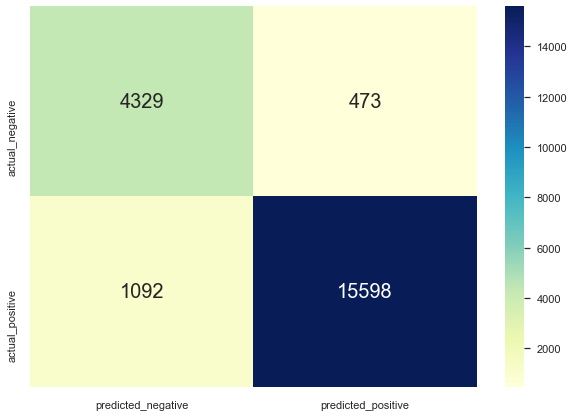

In [315]:
LR_CLF_2X.fit(X_train_tf , y_train)
y_pred_tf4 = LR_CLF_2X.predict(X_val1_tf)
cm8 = conf_matrix(y_val , y_pred_tf4)

**Here wighted LR didnt improve the accuracy and f1-score so its balanced data**

# Ada Boost

In [302]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=0)
AB_CLF.fit(X_train_cv , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train_cv,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val1_cv,y_val))

The accuracy for training :  0.8689256394879961
The accuracy for validation:  0.8691140889633352


In [303]:
AB_CLF.fit(X_train_tf , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train_tf,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val1_tf,y_val))

The accuracy for training :  0.8683078640997539
The accuracy for validation:  0.8680904522613065


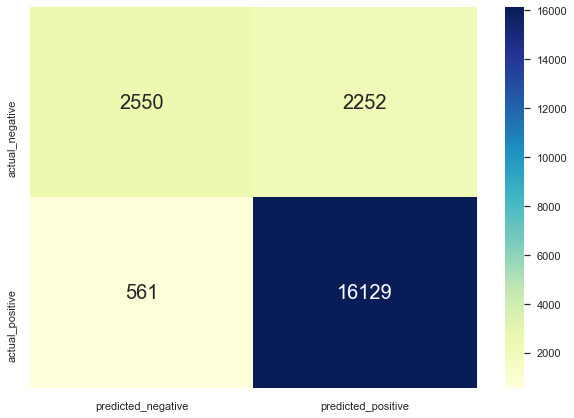

In [316]:
AB_CLF.fit(X_train_cv , y_train)
y_pred_cv5 = AB_CLF.predict(X_val1_cv)
cm9 = conf_matrix(y_val , y_pred_cv5)

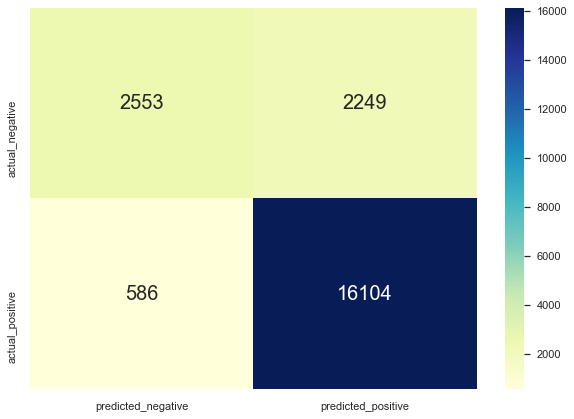

In [317]:
AB_CLF.fit(X_train_tf , y_train)
y_pred_tf5 = AB_CLF.predict(X_val1_tf)
cm10 = conf_matrix(y_val , y_pred_tf5)

In [319]:
results = pd.DataFrame(list(zip(cm1,cm2,cm3,cm4,cm5,cm6,cm7,cm8,cm9,cm10)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['logreg_cv','logreg_tf','Multinomial_cv','Multinomial_tf','Bernoulli_cv','Bernoulli_tf','LogReg_Weighted_cv','LogReg_Weighted_tf','ada_boost_cv','ada_boost_tf']
results





,logreg_cv,logreg_tf,Multinomial_cv,Multinomial_tf,Bernoulli_cv,Bernoulli_tf,LogReg_Weighted_cv,LogReg_Weighted_tf,ada_boost_cv,ada_boost_tf
Accuracy,0.936,0.937,0.892,0.898,0.872,0.872,0.928,0.927,0.869,0.868
Precision,0.947,0.947,0.938,0.900,0.911,0.911,0.967,0.971,0.877,0.877
Recall,0.972,0.974,0.922,0.977,0.926,0.926,0.938,0.935,0.966,0.965
F1 Score,0.959,0.960,0.930,0.937,0.918,0.918,0.952,0.953,0.919,0.919


**here are the results that shows Accuracy , Precision , Recall and F1 Score for each model**

# Final Result (Logistic Regression)

In [306]:
X_train_val = pd.concat([X_train , X_val])
y_train_val = pd.concat([y_train , y_val])

In [307]:
C_vectorizer = CountVectorizer(min_df=100,tokenizer=my_tokenizer, stop_words= stop_words ).fit(X_train_val)
X_train_cvـ = C_vectorizer.transform(X_train_val)
X_test_cvـ = C_vectorizer.transform(X_test)

In [322]:
lr.fit(X_train_cvـ, y_train_val)
print('The accuracy for training and validation : ',lr.score(X_train_cvـ,y_train_val))
print('The accuracy for test: ',lr.score(X_test_cvـ,y_test))

The accuracy for training and validation :  0.9444049916251188
The accuracy for test:  0.934164611734053


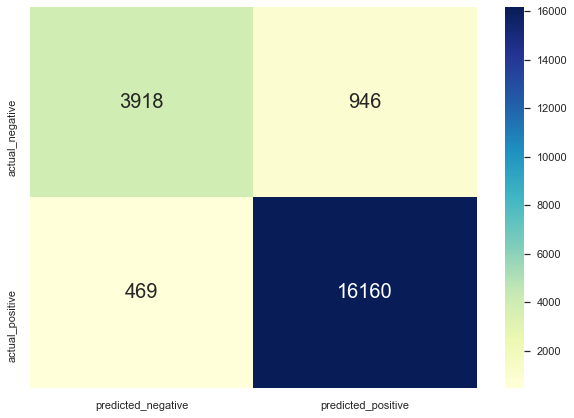

In [324]:
lr.fit(X_train_cvـ , y_train_val)
y_pred_test = lr.predict(X_test_cvـ)
cm0 = conf_matrix(y_test , y_pred_test)

In [325]:
results = pd.DataFrame(list(zip(cm0)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['logreg_test_cv']
results

,logreg_test_cv
Accuracy,0.934
Precision,0.945
Recall,0.972
F1 Score,0.958


# Conclusion

- There was no overfit with high f1-score.
- Logistic regression was best model.
- For topics NMF(6) with count vectorizer was the best. 
- Yelp reviews is more on restaurants and food.
